In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

from cryptic_rnn import *

# Functions

# RNN setup

In [172]:
## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 

def run_exp(trainseqs_old, trainseqs_old_p, testseqs_old, cue_dict, num_inputs):
    """ assigns integers to symbols and trains RNN on sequence - evaluating on test set on each trial"""
    # assigning value to symbol and calculating trial outputs
    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load train and test trials
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

    trainseqs = change_dict(trainseqs_old_p, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_p = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs, hidden_size)
    
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs, hidden_size)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset,
           'loss_p':loss2, 'acc_p':acc2, 'mod_p': model_p}

def test_run(trainseqs, trainseqs_p, testseqs, cue_dict, num_inputs):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, trainseqs_p, testseqs, cue_dict, num_inputs) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    loss = np.hstack([r['loss'] for r in res])
    acc_train = np.array( [r['acc'][:,0] for r in res]).T
    acc_test = np.array( [r['acc'][:,1] for r in res]).T

    loss_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array( [r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array( [r['acc_p'][:,1] for r in res]).T
    
    plotNNs([loss], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = ' no prims', shift = 0)
    plotNNs([loss_p], [acc_train_p, acc_test_p], \
        ['train', 'test'], colors = ['green', 'orange'], title = ' no prims', shift = 0)

def collect_accs(trainseqs, trainseqs_p, testseqs, cue_dict, num_inputs):
    """ trains RNNs in parallel and collects r^2 and acc vals"""
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, trainseqs_p, testseqs, cue_dict, num_inputs) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    
    mods = [r['mod'] for r in res]
    acc_train_list = [r['acc'][:,0] for r in res]
    epoch_list = [find_99_r2_idx(t_acc) for t_acc in acc_train_list]
    acc_test_list = [r['acc'][:,1] for r in res]
    acc_train = np.array(acc_train_list).T
    acc_test = np.array(acc_test_list).T

    mods_p = [r['mod_p'] for r in res]
    acc_train_list_p = [r['acc_p'][:,0] for r in res]
    epoch_list_p = [find_99_r2_idx(t_acc) for t_acc in acc_train_list_p]
    acc_test_list_p = [r['acc_p'][:,1] for r in res]
    acc_train_p = np.array(acc_train_list_p).T
    acc_test_p = np.array(acc_test_list_p).T
       
    acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_train_p': acc_train_p[-1,:],\
                          'acc_test': acc_test[-1,:], 'acc_test_p': acc_test_p[-1,:]})
    
    # fully trained
    fully_trained = acc_df[(acc_df['acc_train'] == 1)&(acc_df['acc_train_p'] == 1)]
    fully_trained_idx = fully_trained.index
    ft_mods = [mods[i] for i in fully_trained_idx]
    print('fully trained models: ',len(ft_mods))
    
    if len(ft_mods) > 0:
        
        ft_tests = [tests[i] for i in fully_trained_idx]
        ft_mods_p = [mods_p[i] for i in fully_trained_idx]

        ft_tests_acc = np.array([acc_test_list[i] for i in fully_trained_idx]).T
        ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
        final_acc = np.mean(ft_tests_acc[-1,:])
        final_acc_std = np.std(ft_tests_acc[-1,:])
        ft_epoch = [epoch_list[i] for i in fully_trained_idx]
        
        ft_tests_acc_p = np.array([acc_test_list_p[i] for i in fully_trained_idx]).T
        ft_train_acc_p = np.array([acc_train_list_p[i] for i in fully_trained_idx]).T
        final_acc_p = np.mean(ft_tests_acc_p[-1,:])
        final_acc_std_p = np.std(ft_tests_acc_p[-1,:])
        ft_epoch_p = [epoch_list_p[i] for i in fully_trained_idx]

        r2, dfs, alldfs = predcorr(ft_mods, ft_tests, hidden_size, plot_corr = False)
        r2_p, dfs_p, alldfs = predcorr(ft_mods_p, ft_tests, hidden_size, plot_corr =False)
        
        print('no prims R^2: ', r2, '; acc = ', final_acc)
        print('with prims R^2: ', r2_p, '; acc = ', final_acc_p)

    else:
        r2, dfs, final_acc = 0, 0, 0
        r2_p, dfs_p, final_acc_p = 0, 0, 0
        
    return {'res':res, 'mods':mods, 'mods_p':mods_p, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df,\
           'dfs':dfs, 'dfs_p':dfs_p, 'r2':r2, 'r2_p':r2_p, 'final_acc':final_acc, 'final_acc_p': final_acc_p,\
           'final_acc_std':final_acc, 'final_acc_std_p': final_acc_p,\
           'ft_train_acc':ft_train_acc,'ft_train_acc_p':ft_train_acc_p}


def generate_pairs(op, inputs, cue_dict, shift):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    for s in range(shift):
        inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [(op, inputs1[i]), (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_complex_primitives(op, inputs, cue_dict):
    seq = []
    all_inputs = inputs.copy()
    random.shuffle(all_inputs)
    for q in range(int(len(all_inputs)/2)):
        trial = [(op, all_inputs[2*q]), (op, all_inputs[2*q+1]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def find_99_acc_idx(acc_vals):
    count = 0
    thresh_idx = -1
    for i, rval in enumerate(acc_vals):
        if rval > 0.99:
            count +=1
        else:
            count = 0
        if count > 10:
            thresh_idx = i - 10
            break
    return thresh_idx

def input_frac_run(num_inputs, max_inputs):
    
    all_syms = total_syms[:num_inputs]
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    print('cue_dict: ', cue_dict)
    primitives = generate_pos_primitives(all_syms, cue_dict)
    print('primitives: ', primitives)
    trial_list = []
    for s in range(1, len(all_syms)+1):
        trial_list += (generate_pairs(ops, all_syms, cue_dict, s))
    print('no train trials = ', len(trial_list))
    print(trial_list[:4])
    
    # collect accuracies
    r2s = []
    r2s_p = []
    acc_fin = []
    acc_fin_p = []
    acc_fin_std = []
    acc_fin_std_p = []
    acc_train = []
    acc_train_p = []

    for j in range(1, max_inputs+2):
        print('##################\nnumber of train trials: ',j)
        num_train = j
        train_trials = trial_list.copy()
        complex_prims = generate_complex_primitives(ops, all_syms, cue_dict)
        train_trials = [trial for trial in train_trials if trial not in complex_prims] # remove primitive trials from train list
        basic_train = train_trials[:num_train]
        trainseqs = basic_train + complex_prims
        trainseqs_p = basic_train + primitives
        testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
        testseqs = [t for t in testseqs if t not in trainseqs]
        print('trainseqs ', trainseqs)
        print('testseqs ', testseqs )
        
        res1 = collect_accs(trainseqs, trainseqs_p, testseqs, cue_dict, num_inputs)
        
        if res1['r2'] > 0:
            fig, ax = plt.subplots(1,2)
            heatmap_acc_sign(num_inputs, res1['dfs'], ax[0])
            heatmap_acc_sign(num_inputs, res1['dfs_p'], ax[1])

        r2s.append(res1['r2'])
        r2s_p.append(res1['r2_p'])
        acc_fin.append(res1['final_acc'])
        acc_fin_p.append(res1['final_acc_p'])
        acc_fin_std.append(res1['final_acc_std'])
        acc_fin_std_p.append(res1['final_acc_std_p'])
        acc_train.append(res1['ft_train_acc'])
        acc_train_p.append(res1['ft_train_acc_p'])
         
    return {'r2s': r2s, 'r2s_p': r2s_p, 'acc_fin': acc_fin, 'acc_fin_p': acc_fin_p,\
           'acc_fin_std': acc_fin_std, 'acc_fin_std_p': acc_fin_std_p, \
           'acc_train': acc_train, 'acc_train_p': acc_train_p}


def plot_accs(res):
    
    acc_fin = res['acc_fin']
    acc_fin_p = res['acc_fin_p']
    acc_fin_std = res['acc_fin_std']
    acc_fin_std_p = res['acc_fin_std_p']
    r2s = res['r2s']
    r2s_p = res['r2s_p']
    
    # plot accuracies with error bars
    fig, ax = plt.subplots(1,2)
    x = np.arange(len(acc_fin))
    xp = np.arange(len(acc_fin_p))
    acc_fin = np.array(acc_fin)
    acc_fin_p = np.array(acc_fin_p)
    acc_fin_std = np.array(acc_fin_std)
    acc_fin_std_p = np.array(acc_fin_std_p)
    ax[0].plot(x, acc_fin, color = 'red', label='without primitives')
    ax[0].fill_between(x, acc_fin - acc_fin_std, acc_fin + acc_fin_std, alpha = 0.3, facecolor = 'red')
    ax[0].plot(xp, acc_fin_p, color = 'blue', label='with primitives')
    ax[0].fill_between(xp, acc_fin_p - acc_fin_std_p, acc_fin_p + acc_fin_std_p, alpha = 0.3, facecolor = 'blue')
    ax[0].set_xlabel('no. training trials')
    ax[0].set_ylabel('test accuracy')
    ax[0].set_ylim(0,1.1)
    ax[0].set_xticks(np.arange(0, len(x)))
    ax[0].set_xticklabels(np.arange(1, len(x)+1))
    ax[0].legend()
    ax[0].title.set_text('RNN test accuracy')
    
    # plot R^2
    ax[1].plot(np.arange(len(r2s)), r2s, label='without primitives', color='red')
    ax[1].plot(np.arange(len(r2s_p)), r2s_p, label='with primitives', color='blue')
    ax[1].set_ylim(-0.2,1.2)
    ax[1].set_xlabel('no. training trials')
    ax[1].set_ylabel('R squared')
    ax[1].set_xticks(np.arange(0, len(x)))
    ax[1].set_xticklabels(np.arange(1, len(x)+1))
    ax[1].legend()
    ax[1].title.set_text('model prediction vs ground truth R^2 values')
    
    
def plot_epochs(res):
    mn = []
    std = []
    mn_p = []
    std_p = []
    for j in range(len(res['acc_train'])):
        mn.append(np.apply_along_axis(find_99_acc_idx, 0, res['acc_train'][j]).mean())
        std.append(np.apply_along_axis(find_99_acc_idx, 0, res['acc_train'][j]).std())
        mn_p.append(np.apply_along_axis(find_99_acc_idx, 0, res['acc_train_p'][j]).mean())
        std_p.append(np.apply_along_axis(find_99_acc_idx, 0, res['acc_train_p'][j]).std())

    mn = np.array(mn)
    std = np.array(std)
    mn_p = np.array(mn_p)
    std_p = np.array(std_p)
    x = np.arange(0, len(res['acc_train']))
    plt.figure()
    plt.plot(mn, color = 'red', label = 'without primitives')
    plt.fill_between(x, mn - std, mn + std, alpha = 0.3, facecolor = 'red')
    plt.plot(mn_p, color='blue', label = 'with primitives')
    plt.fill_between(x, mn_p - std_p, mn_p + std_p, alpha = 0.3, facecolor = 'blue')
    plt.xlabel('train trials')
    plt.ylabel('no. epochs')
    plt.legend()
    plt.title('Number of epochs for 100% train accuracy')



In [144]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 12
num_sims = 8

# 
xavier_gain = 0.0001

# seq
ops = '+'
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_input_vals = list(np.arange(2,18))

epochs = 1500
num_sims = 400


# Experiments

Compare final accuracy and R^2 with and without primitives across number of training trials / total
Efficiency of training: number of epochs until reached 100% train efficiency

For 3,4,5,6..(7?) input symbols

In [119]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)

pos_primitives = generate_pos_primitives(all_syms, cue_dict)
print(pos_primitives)

{'A': 12, 'B': 2, 'C': 15, 'D': 14}
[[('+', 'A'), '=', 12], [('+', 'B'), '=', 2], [('+', 'C'), '=', 15], [('+', 'D'), '=', 14]]


run time:  1.1005095362663269


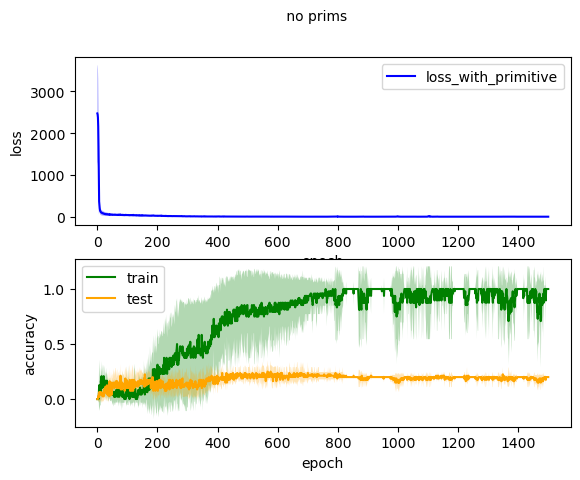

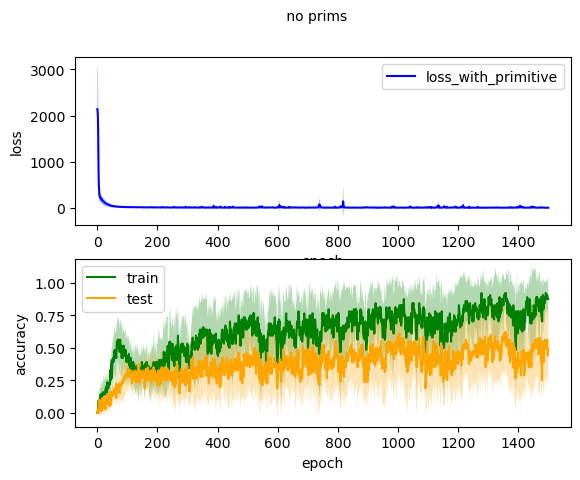

In [125]:
trainseqs_old = generate_pos_other(ops, all_syms, cue_dict) + generate_complex_primitives(ops, all_syms, cue_dict)
trainseqs_old_p = generate_pos_other(ops, all_syms, cue_dict) + pos_primitives
testseqs_old = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs_old = [seq for seq in testseqs_old if seq not in trainseqs_old]

num_sims = 8
test_run(trainseqs_old, trainseqs_old_p, testseqs_old, cue_dict, num_inputs)

# no. inputs = 4

cue_dict:  {'A': 2, 'B': 5, 'C': 4, 'D': 9}
primitives:  [[('+', 'A'), '=', 2], [('+', 'B'), '=', 5], [('+', 'C'), '=', 4], [('+', 'D'), '=', 9]]
no train trials =  16
[[('+', 'A'), ('+', 'B'), '=', 7], [('+', 'B'), ('+', 'C'), '=', 9], [('+', 'C'), ('+', 'D'), '=', 13], [('+', 'D'), ('+', 'A'), '=', 11]]
##################
number of train trials:  1
trainseqs  [[('+', 'A'), ('+', 'B'), '=', 7], [('+', 'A'), ('+', 'C'), '=', 6], [('+', 'B'), ('+', 'D'), '=', 14]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 4], [('+', 'A'), ('+', 'D'), '=', 11], [('+', 'B'), ('+', 'A'), '=', 7], [('+', 'B'), ('+', 'B'), '=', 10], [('+', 'B'), ('+', 'C'), '=', 9], [('+', 'C'), ('+', 'A'), '=', 6], [('+', 'C'), ('+', 'B'), '=', 9], [('+', 'C'), ('+', 'C'), '=', 8], [('+', 'C'), ('+', 'D'), '=', 13], [('+', 'D'), ('+', 'A'), '=', 11], [('+', 'D'), ('+', 'B'), '=', 14], [('+', 'D'), ('+', 'C'), '=', 13], [('+', 'D'), ('+', 'D'), '=', 18]]
run time:  2.912184981505076
fully trained models:  40
no prims R^2:  -0

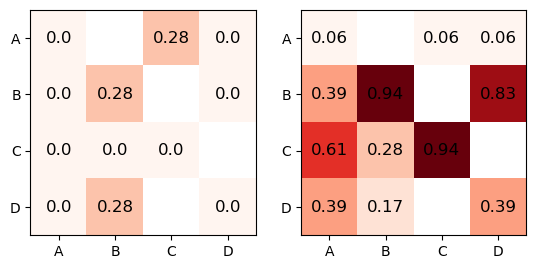

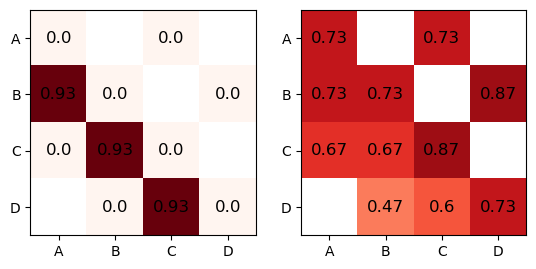

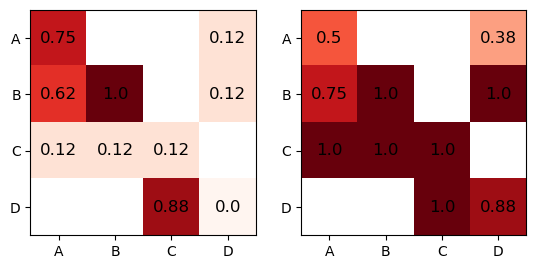

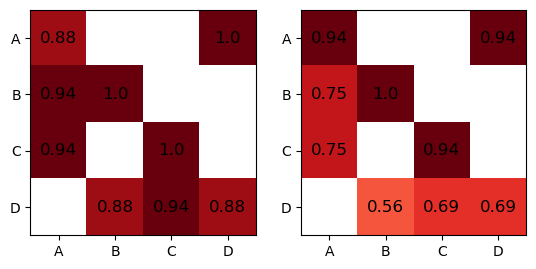

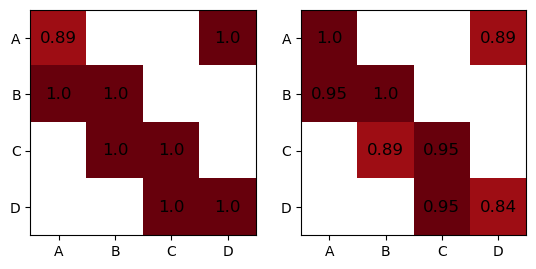

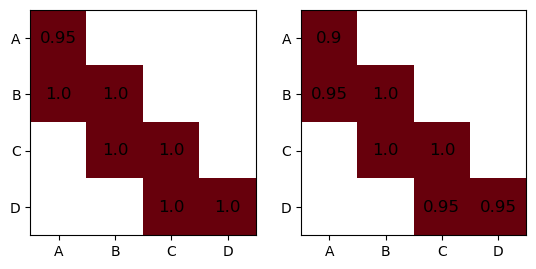

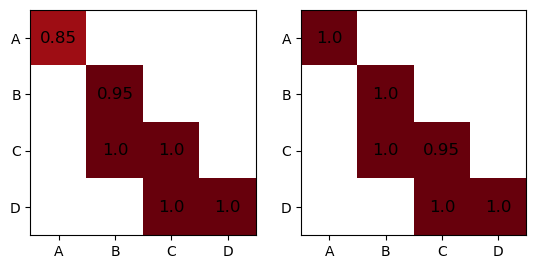

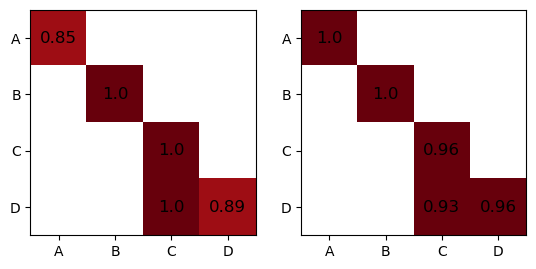

In [148]:
num_sims=40
epochs = 1000
res_4 = input_frac_run(4, 8)

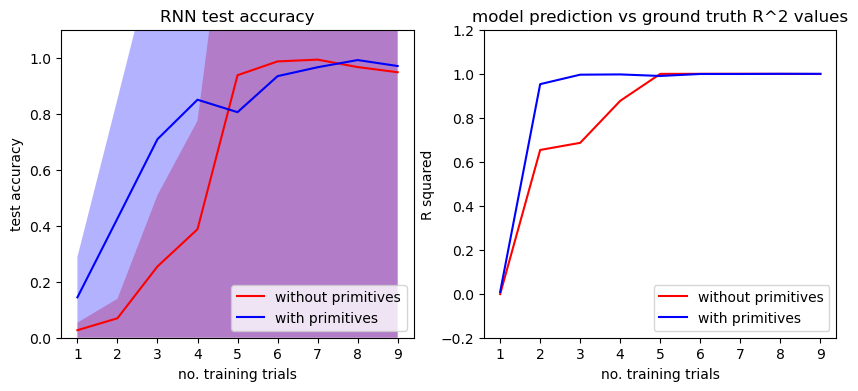

In [173]:
plt.rcParams["figure.figsize"] = (10,4)
plot_accs(res_4)


In [ ]:
plot_epochs(res_4)